In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir FruitDetection

In [ ]:
!unzip "/content/drive/MyDrive/FruitDetection/archive.zip" -d "/content/FruitDetection/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/FruitDetection/train/train/Pepper Green/Pepper Green_264.jpg  
  inflating: /content/FruitDetection/train/train/Pepper Green/Pepper Green_265.jpg  
  inflating: /content/FruitDetection/train/train/Pepper Green/Pepper Green_266.jpg  
  inflating: /content/FruitDetection/train/train/Pepper Green/Pepper Green_267.jpg  
  inflating: /content/FruitDetection/train/train/Pepper Green/Pepper Green_268.jpg  
  inflating: /content/FruitDetection/train/train/Pepper Green/Pepper Green_269.jpg  
  inflating: /content/FruitDetection/train/train/Pepper Green/Pepper Green_27.jpg  
  inflating: /content/FruitDetection/train/train/Pepper Green/Pepper Green_270.jpg  
  inflating: /content/FruitDetection/train/train/Pepper Green/Pepper Green_271.jpg  
  inflating: /content/FruitDetection/train/train/Pepper Green/Pepper Green_272.jpg  
  inflating: /content/FruitDetection/train/train/Pepper Green/Pepper Green_273.jpg  
  inflating: /c

In [ ]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.9 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from IPython.display import Image
import timm #architectures for image classications
from tqdm import tqdm

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


In [ ]:
class FruitDataset(Dataset):
	def __init__(self, data_dir, transform=None):
		self.data = ImageFolder(data_dir, transform=transform)

	def __len__(self):
		return len(self.data)

	def __getitem__(self, idx):
		return self.data[idx]

	@property
	def classes(self):
		return self.data.classes

In [ ]:
dataset = FruitDataset(data_dir="/content/FruitDetection/train/train/")

In [ ]:
print(f'Rows in dataset: {len(dataset)}')

16854

In [ ]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
class FruitClassifier(nn.Module):
	def __init__(self, numClasses=33):
		# define all the parts of the model
		super(FruitClassifier, self).__init__()
		self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
		self.features = nn.Sequential(*list(self.base_model.children())[:-1])
		enet_out_size = 1280
		# make a classifier
		self.classifier = nn.Linear(enet_out_size, numClasses)

	def forward(self, x):
		# Connect these parts and return the output
		x = self.features(x)
		output = self.classifier(x)
		return output

In [ ]:
model = FruitClassifier(numClasses=33)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_folder = '/content/FruitDetection/train/train/'

train_dataset = FruitDataset(train_folder, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [ ]:
num_epochs = 5
train_losses = []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = FruitClassifier(numClasses=33)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc='Training loop'):
        # Move inputs and labels to the device
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)


Training loop: 100%|██████████| 527/527 [00:39<00:00, 13.45it/s]


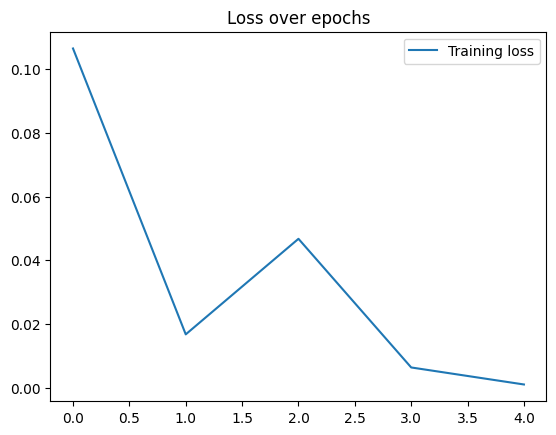

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

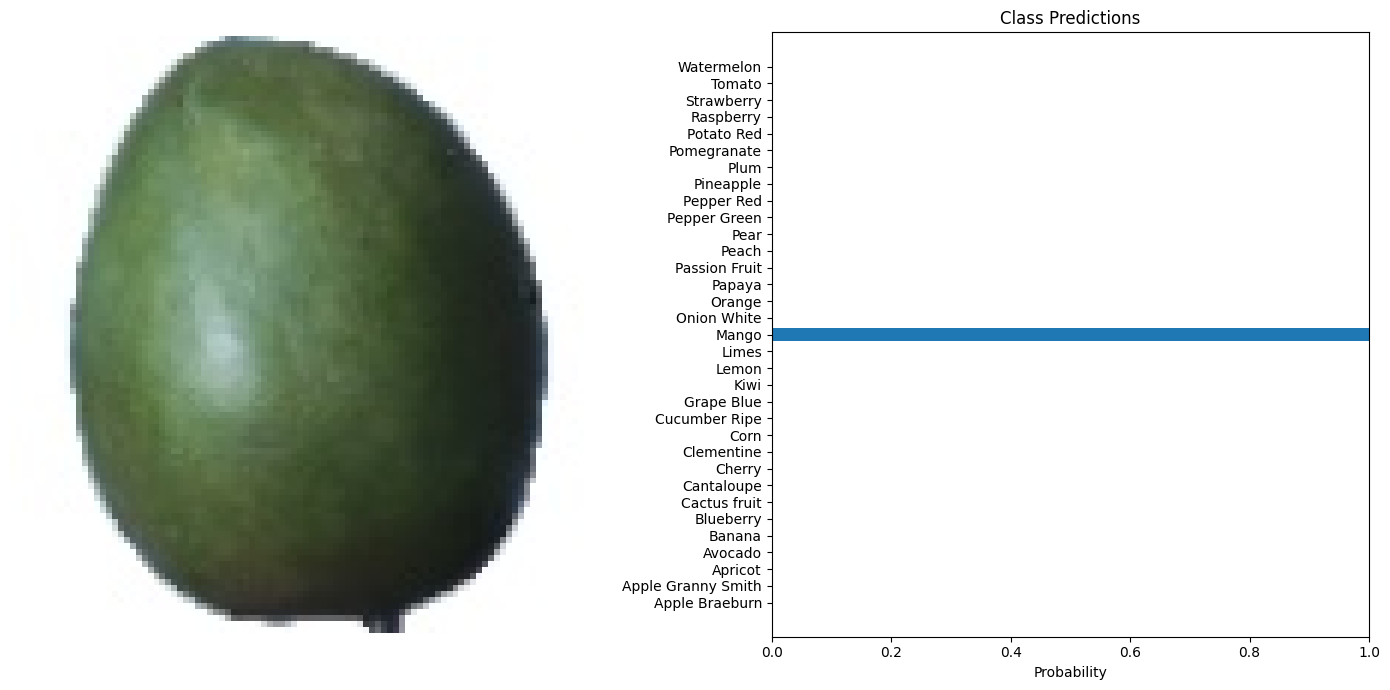

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load and preprocess the image
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)

# Predict using the model
def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy().flatten()

# Visualization
def visualize_predictions(original_image, probabilities, class_names):
    fig, axarr = plt.subplots(1, 2, figsize=(14, 7))

    # Display image
    axarr[0].imshow(original_image)
    axarr[0].axis("off")

    # Display predictions
    axarr[1].barh(class_names, probabilities)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Class Predictions")
    axarr[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

# Example usage
test_image = "/content/FruitDetection/test/test/0004.jpg"
transform = transforms.Compose([
    transforms.ToTensor()
])

original_image, image_tensor = preprocess_image(test_image, transform)
probabilities = predict(model, image_tensor, device)

# Assuming dataset.classes gives the class names
class_names = dataset.classes
visualize_predictions(original_image, probabilities, class_names)